# In this dataset

1. does it match the statistics of a high dimensional grid representation
2. Is the taurus real
3. test whether you can do the grid realignment like carpenter also in the big maze
4. show that correlation structure is preserved only in as far as cells are spatial

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import seaborn
import pandas as pd
#import cv2
import scipy.optimize as op
import sys
import networkx as nx
import time
import matplotlib
import copy as cp
import scipy.ndimage as ndi 
from scipy.ndimage import gaussian_filter1d
import scipy as sp
import scipy.signal
seaborn.set(style='ticks',font_scale=1.5)

sys.path.append('/Users/yves/Documents/Code/mec_ephys/packages')


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
sys.path.append('/Users/yves/Documents/Code/mec_ephys/packages')

from mecll.rsync import Rsync_aligner
from mecll.proc_beh import get_all_transition, get_transitions_state, build_poke_df
from mecll.proc_neural import get_all_resps, get_mean_resps
from mecll.load import load_data


ModuleNotFoundError: No module named 'mecll.proc_beh'

In [3]:
sys.path.append('/Users/yves/Documents/Code/mec_ephys/packages')

from mecll.rsync import Rsync_aligner
from mecll.process_data.proc_beh import get_all_transitions, get_transitions_state, build_poke_df
from mecll.process_data.proc_neural import get_all_resps, get_mean_resps
from mecll.load import load_data
from mecll.SVD_analysis import get_mean_activity_matrix, variance_explained_both, variance_explained_U, variance_explained_U
from mecll.utils import align_activity

In [4]:
poke_pos = np.array([1,-1])*np.array([ [149,0],
                                 [68,19],[231,19],
                               [0,62],[149,62],[298,62],
                                 [68,105],[231,105],
                                      [149,124]])

# From pycontrol

In [5]:
#Load behavioural data
root_path = '/Users/yves/team_mouse Dropbox/MEC_data/spike_sorted/2021-08-06_39964_ks25/'
#'/Users/yves/Downloads/example_files2_wOF//'

out = load_data(root_path)
spkT,spkC,single_units,events,lines,aligner = out

567 567


In [6]:
df = build_poke_df(lines,events)


In [7]:
poke_dict_t1 ={}
poke_dict_t2 = {}
for port_nr in np.unique(df['port'].values):
    for task_nr in range(2):
        task_nr = str(task_nr)
        v = df.loc[(df['port']==port_nr) &
                   (df['correct']==True) & 
                   (df['reward']==True) &
                   #(df['next_correct']==True) &
                   (df['port_repeat']==False) & 
                   (df['task_nr']==task_nr)]['time'].values
        #v = np.array(v).astype('float')
        if task_nr=='0':
            print(task_nr,len(v),str(port_nr),)
            poke_dict_t1[str(port_nr)] = [float(i) for i in v]
            poke_dict_t1['task_nr'] = str(task_nr)
            poke_dict_t1['graph_type'] = df.loc[df['task_nr']==task_nr]['graph_type'].values[0]

            poke_dict_t1['seq'] = df.loc[df['task_nr']==task_nr]['current_sequence'].values[0]

        else:
            poke_dict_t2[str(port_nr)] = [float(i) for i in v]
            poke_dict_t2['task_nr'] = str(task_nr)
            poke_dict_t2['graph_type'] = df.loc[df['task_nr']==task_nr]['graph_type'].values[0]
            poke_dict_t2['seq'] = df.loc[df['task_nr']==task_nr]['current_sequence'].values[0]

   

0 8 0
0 14 1
0 15 2
0 12 3
0 15 4
0 7 5
0 9 6
0 16 7
0 13 8


In [8]:
from scipy.ndimage import gaussian_filter1d

In [9]:
def get_mean_activity_matrix(single_trial_resps,order=None,half=0,downsample_factor=150,smoothing_factor=10):
    
    """ This builds a matrix that describes how mean activity
        evolves over time
    """
    
    if order is None:
        order = np.arange(9)

    n_units = len(single_trial_resps)
    store_g1 = []

    for neuron_ix in range(n_units):
        tmp = [] 
        for poke_nr in order:
            activity = np.array(single_trial_resps[neuron_ix][poke_nr])
            #print(np.sum(activity))
            if half==0:
                mean_activity = np.mean(activity,axis=0)
            elif half==1:
                mean_activity = np.mean(activity[:int(len(activity)/2)],axis=0)
            elif half==2:
                mean_activity = np.mean(activity[int(len(activity)/2):],axis=0)
                

            mean_downsampled = mean_activity.reshape(-1,downsample_factor).mean(axis=1)
            mean_downsampled_smoothed = gaussian_filter1d(mean_downsampled,smoothing_factor)
            tmp.append(mean_downsampled_smoothed)
        store_g1.append(np.hstack(tmp))
    return np.array(store_g1)

# assess stability

In [10]:
out1 = get_all_resps(aligner,poke_dict_t1,single_units,spkT,spkC)
all_resps_g1_single_trial, (all_resps1_g1_single_trial,all_resps2_g1_single_trial) = out1
out2 = get_all_resps(aligner,poke_dict_t2,single_units,spkT,spkC)
all_resps_g2_single_trial, (all_resps1_g2_single_trial,all_resps2_g2_single_trial) = out2

In [11]:
all_resps_g1,_ = get_mean_resps(all_resps_g1_single_trial)
all_resps_g2,_ = get_mean_resps(all_resps_g2_single_trial)


all_resps1_g1,_ = get_mean_resps(all_resps1_g1_single_trial)
all_resps1_g2,_ = get_mean_resps(all_resps1_g2_single_trial)

all_resps2_g1,_ = get_mean_resps(all_resps2_g1_single_trial)
all_resps2_g2,_ = get_mean_resps(all_resps2_g2_single_trial)

In [18]:
def get_with_and_across_correlations(all_resps1_g1,all_resps2_g1,all_resps1_g2,all_resps2_g2):
    
    """ Get correlations between neural activity across behaivour on the two different graphs
        as well as across split halves of the same graph
    """

    ccs_within1 = []
    for r1,r2 in zip(all_resps1_g1,all_resps2_g1):
        ccs_within1.append(np.corrcoef(r1,r2)[0,1])

    ccs_within1 = np.array(ccs_within1)
    print(np.nanmean(ccs_within1))

    ccs_within2 = []
    for r1,r2 in zip(all_resps1_g2,all_resps2_g2):
        ccs_within2.append(np.corrcoef(r1,r2)[0,1])
    ccs_within2 = np.array(ccs_within2)

    print(np.nanmean(ccs_within2))


    ccs_within = (np.array(ccs_within1) + np.array(ccs_within2))/2.
    ccs_within = np.min(np.vstack([np.array(ccs_within1),np.array(ccs_within2)]),axis=0)


    #
    ccs_across = []
    for r1,r2 in zip(all_resps_g1,all_resps_g2):
        ccs_across.append(np.corrcoef(r1,r2)[0,1])

    ccs_across = np.array(ccs_across)
    print(np.nanmean(ccs_across))
    
    return ccs_within,ccs_across,(ccs_within1,ccs_within2)

In [19]:
ccs_within,ccs_across,(ccs_within1,ccs_within2) = get_with_and_across_correlations(all_resps1_g1,all_resps2_g1,all_resps1_g2,all_resps2_g2)

0.46506679477424984
0.4375418069693818
0.4825456365188936


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


# make it work

In [13]:
window0 = 6000
window1 = 6000
out1 = get_all_resps(aligner,poke_dict_t1,single_units,spkT,spkC,get_time_mean=False,
                     window0=window0,window1=window1)
all_resps_g1_single_trial, (all_resps1_g1_single_trial,all_resps2_g1_single_trial) = out1
out2 = get_all_resps(aligner,poke_dict_t2,single_units,spkT,spkC,get_time_mean=False,
                     window0=window0,window1=window1)
all_resps_g2_single_trial, (all_resps1_g2_single_trial,all_resps2_g2_single_trial) = out2

In [14]:
store_g1_p1 = get_mean_activity_matrix(all_resps_g1_single_trial,half=1)
store_g1_p2 = get_mean_activity_matrix(all_resps_g1_single_trial,half=2)

store_g2_p1 = get_mean_activity_matrix(all_resps_g2_single_trial,half=1)
store_g2_p2 = get_mean_activity_matrix(all_resps_g2_single_trial,half=2)

In [15]:
store_g1_p1 = get_mean_activity_matrix(all_resps_g1_single_trial,half=1,order=poke_dict_t1['seq'])
store_g1_p2 = get_mean_activity_matrix(all_resps_g1_single_trial,half=2,order=poke_dict_t1['seq'])

store_g2_p1 = get_mean_activity_matrix(all_resps_g2_single_trial,half=1,order=poke_dict_t2['seq'])
store_g2_p2 = get_mean_activity_matrix(all_resps_g2_single_trial,half=2,order=poke_dict_t2['seq'])

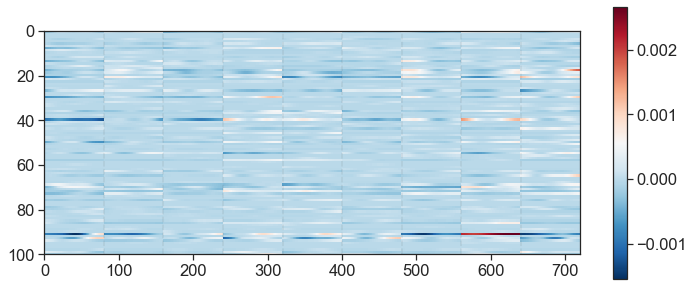

In [16]:
plt.figure(figsize=(12,5))
plt.imshow(store_g1_p1-np.mean(store_g1_p1,axis=1)[:,None],cmap='RdBu_r',interpolation='None',aspect=3)
for ii in range(9):
    plt.axvline(x=ii*80,linestyle='--',color='.3',alpha=.1)
plt.ylim(100,0)
plt.colorbar()

In [58]:
evals_shuff = []
for ctr in range(100):
    sys.stdout.write('\riter_num:{}'.format(ctr))
    sys.stdout.flush()
    store_g1_p1 = get_mean_activity_matrix(all_resps_g1_single_trial,half=1,order=poke_dict_t1['seq'])
    store_g1_p2 = get_mean_activity_matrix(all_resps_g1_single_trial,half=2,order=np.random.permutation(poke_dict_t1['seq']))

    store_g2_p1 = get_mean_activity_matrix(all_resps_g2_single_trial,half=1,order=np.random.permutation(poke_dict_t2['seq']))
    store_g2_p2 = get_mean_activity_matrix(all_resps_g2_single_trial,half=2,order=np.random.permutation(poke_dict_t2['seq']))
    

    #conditions =  np.logical_and.reduce([ccs_across<.3,
    #                                    ccs_within>=.3])
    conditions = ccs_within>.1
    store_g1_filt = store_g1_p1[conditions]
    store_g1_cv_filt = store_g1_p2[conditions]
    store_g2_filt = store_g2_p1[conditions]
    store_g2_cv_filt = store_g2_p2[conditions]
    
    
    U,D,V = np.linalg.svd(store_g1_filt)
    #U2,D2,V2 = np.linalg.svd(store_g2_filt)
    evals = U.T.dot(store_g2_filt).dot(V.T).diagonal()
    evals_shuff.append(evals)


iter_num:9

KeyboardInterrupt: 

In [59]:
store_g1_p1 = get_mean_activity_matrix(all_resps_g1_single_trial,half=1,order=poke_dict_t1['seq'])
store_g1_p2 = get_mean_activity_matrix(all_resps_g1_single_trial,half=2,order=poke_dict_t1['seq'])

store_g2_p1 = get_mean_activity_matrix(all_resps_g2_single_trial,half=1,order=poke_dict_t2['seq'])
store_g2_p2 = get_mean_activity_matrix(all_resps_g2_single_trial,half=2,order=poke_dict_t2['seq'])

In [60]:

conditions =  np.logical_and.reduce([ccs_across<99,
                                    ccs_within>=.3])
store_g1_filt = store_g1_p1[conditions]
store_g1_filt = store_g1_filt - np.mean(store_g1_filt,axis=1)[:,None]
#store_g1_filt = store_g1_filt/np.std(store_g1_filt,axis=1)[:,None]

store_g1_cv_filt = store_g1_p2[conditions]
store_g1_cv_filt = store_g1_cv_filt - np.mean(store_g1_cv_filt,axis=1)[:,None]

store_g2_filt = store_g2_p1[conditions]
store_g2_filt = store_g2_filt - np.mean(store_g2_filt,axis=1)[:,None]
#store_g2_filt = store_g1_filt/np.var(store_g2_filt,axis=1)[:,None]

store_g2_cv_filt = store_g2_p2[conditions]
store_g2_cv_filt = store_g2_cv_filt - np.mean(store_g2_cv_filt,axis=1)[:,None]


In [35]:


def variance_explained_both(store_ref,store_cv,store_alt):

    U,S,V = np.linalg.svd(store_ref)

    
    ev_cv = U.T.dot(store_cv).dot(V.T).diagonal()**2
    norm_ev_cv = ev_cv/np.sum(ev_cv)
    
    
    ev_alt = U.T.dot(store_alt).dot(V.T).diagonal()**2
    norm_ev_alt = ev_alt/np.sum(ev_alt)

    
    return norm_ev_cv, norm_ev_alt

In [61]:
ev_cv1_U, ev_alt1_U = variance_explained_U(store_g1_filt,store_g1_cv_filt,store_g2_filt)
ev_cv1_V, ev_alt1_V = variance_explained_V(store_g1_filt,store_g1_cv_filt,store_g2_filt)
ev_cv1_B, ev_alt1_B = variance_explained_both(store_g1_filt,store_g1_cv_filt,store_g2_filt)


ev_cv2_U, ev_alt2_U = variance_explained_U(store_g2_filt,store_g2_cv_filt,store_g1_filt)
ev_cv2_U, ev_alt2_U = variance_explained_V(store_g2_filt,store_g2_cv_filt,store_g1_filt)
ev_cv2_B, ev_alt2_B = variance_explained_both(store_g2_filt,store_g2_cv_filt,store_g1_filt)

In [37]:
Sbig = np.eye(U.shape[0],V.shape[0])
Sbig[np.arange(U.shape[0]),np.arange(U.shape[0])] = S

NameError: name 'S' is not defined

In [38]:
np.allclose(U.dot(Sbig).dot(V),store_g1_filt)

ValueError: operands could not be broadcast together with shapes (7,720) (91,720) 

In [39]:
plt.imshow(tmp_,interpolation='None')

NameError: name 'tmp_' is not defined

In [40]:
#calculate explained variance explained by U
evals_alt = np.sum(U.T.dot(store_g2_filt)**2,axis=1)
norm_evals_alt = evals_alt/np.sum(evals_alt)

ValueError: shapes (7,7) and (91,720) not aligned: 7 (dim 1) != 91 (dim 0)

In [41]:
#calculate explained variance explained by U
evals_cv = np.sum(U.T.dot(store_g1_cv_filt)**2,axis=1)
norm_evals_cv = evals_cv/np.sum(evals_cv)

ValueError: shapes (7,7) and (91,720) not aligned: 7 (dim 1) != 91 (dim 0)

In [42]:
plt.plot(np.cumsum(norm_evals_cv))
plt.plot(np.cumsum(norm_evals_alt))

NameError: name 'norm_evals_cv' is not defined

In [43]:
def variance_explained_U(store_ref,store_cv,store_alt):
    U,S,V = np.linalg.svd(store_ref)
    
    #calculate explained variance explained by U
    ev_cv = np.sum(U.T.dot(store_cv)**2,axis=1)
    norm_ev_cv = ev_cv/np.sum(ev_cv)

    #calculate explained variance explained by U
    ev_alt = np.sum(U.T.dot(store_alt)**2,axis=1)
    norm_ev_alt = ev_alt/np.sum(ev_alt)
        
    return norm_ev_cv, norm_ev_alt

In [44]:
def variance_explained_both(store_ref,store_cv,store_alt):

    U,S,V = np.linalg.svd(store_ref)

    
    ev_cv = U.T.dot(store_cv).dot(V.T).diagonal()**2
    norm_ev_cv = ev_cv/np.sum(ev_cv)
    
    
    ev_alt = U.T.dot(store_alt).dot(V.T).diagonal()**2
    norm_ev_alt = ev_alt/np.sum(ev_alt)

    
    return norm_ev_cv, norm_ev_alt

In [45]:
def variance_explained_V(store_ref,store_cv,store_alt):
    """ Not 100% sure about this one but think its
        correct
    """
    U,S,V = np.linalg.svd(store_ref)
    
    #calculate explained variance explained by U
    ev_cv = np.sum(np.dot(store_cv,V.T)**2,axis=1)
    norm_ev_cv = ev_cv/np.sum(ev_cv)

    #calculate explained variance explained by U
    ev_alt = np.sum(np.dot(store_alt,V.T)**2,axis=1)
    norm_ev_alt = ev_alt/np.sum(ev_alt)
        
    return norm_ev_cv, norm_ev_alt

In [46]:
ev_u1 = variance_explained_U()

TypeError: variance_explained_U() missing 3 required positional arguments: 'store_ref', 'store_cv', and 'store_alt'

In [47]:
np.dot(store_g1_filt,V.T).sum(axis=1)

array([ 6.66205323e-03, -1.10837840e-02,  3.07609680e-03,  1.11171190e-03,
        3.92763303e-03, -8.63616833e-04,  2.72209186e-03,  1.89128009e-02,
        1.84621360e-03, -1.24586754e-03,  1.44167420e-02, -5.39151629e-03,
        1.67743147e-03, -8.19093646e-04,  1.70805243e-02,  1.13311361e-02,
        3.55427093e-04,  1.84970656e-03,  2.76645224e-03, -1.42375155e-02,
        3.67292709e-03, -3.43208177e-03,  3.39027954e-03,  1.45063661e-03,
       -3.68268926e-04,  5.44818377e-03,  7.17212893e-03, -1.06673587e-03,
       -2.13866642e-03, -9.01127928e-03,  7.08047685e-03,  9.88000925e-03,
       -7.43390216e-03,  8.43279668e-03,  2.27891887e-03, -2.05562970e-03,
        7.83465498e-04,  1.46131827e-04, -8.44712300e-03,  1.45381657e-03,
       -8.70592218e-03,  5.34828514e-04, -6.24363125e-03, -3.17224380e-04,
       -1.53221574e-02, -3.71501523e-03, -4.01386671e-02,  3.08193218e-03,
       -3.70899882e-05,  3.93587168e-04, -1.28108311e-03, -8.74904499e-04,
       -1.72974666e-03,  

In [359]:
ccs = []
for ix_ in range(store_g1_filt.shape[1]):
    ccs.append(np.cov(U[:,0],store_g1_filt[:,ix_])[0,1])

In [23]:
import scipy.stats as stt

NameError: name 'true_evals' is not defined

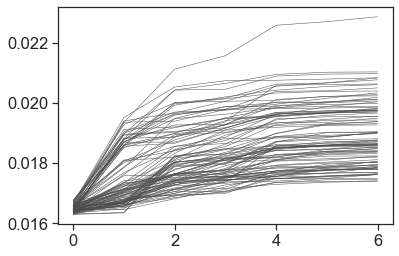

In [53]:
mu = np.mean(np.cumsum(np.abs(evals_shuff),axis=1),axis=1)
for i in np.abs(evals_shuff):
    plt.plot(np.cumsum(i),color='.3',linewidth=.5)
sem =np.std(np.cumsum(np.abs(evals_shuff),axis=1),axis=0)
plt.plot(np.cumsum(np.abs(true_evals)),linewidth=3)
plt.plot(mu,linewidth=3,color='.3',label='shuffle')
plt.fill_between(range(len(mu)),mu+2*sem,mu-2*sem,color='.3',alpha=.3)
plt.legend()
seaborn.despine()

In [65]:
import scipy.stats as stt

In [72]:
stt.linregress(np.sin(np.linspace(0,2*np.pi+np.pi/4,num=100)),np.cos(np.linspace(0,2*np.pi,num=100)))

LinregressResult(slope=0.43105705773907865, intercept=-0.009199134991821187, rvalue=0.411695349884131, pvalue=2.0858276448157374e-05, stderr=0.09638676255442583)

([], <a list of 0 Text yticklabel objects>)

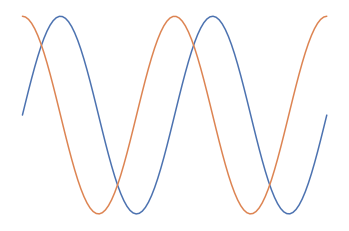

In [71]:
plt.plot(np.sin(np.linspace(0,4*np.pi,num=100)))
plt.plot(np.cos(np.linspace(0,4*np.pi,num=100)))
seaborn.despine(bottom=True,left=True)
plt.xticks([])
plt.yticks([])

In [67]:
store_g1_filt.shape

(91, 1350)

In [68]:
U.shape

(115, 115)

In [54]:
#this is the correct equation to testimate. This returns the corresponding D
evals = np.abs(U.T.dot(store_g1_filt).dot(V.T).diagonal())
mx = np.sum(evals)
plt.plot([0]+(np.cumsum(evals)/mx).tolist())

evals = np.abs(U.T.dot(store_g1_cv_filt).dot(V.T).diagonal())
plt.plot([0]+(np.cumsum(evals)/mx).tolist())


evals = np.abs(U.T.dot(store_g2_filt).dot(V.T).diagonal())
plt.plot([0]+(np.cumsum(evals)/mx).tolist())
#plt.ylim(.2,1)


ValueError: shapes (7,7) and (91,720) not aligned: 7 (dim 1) != 91 (dim 0)

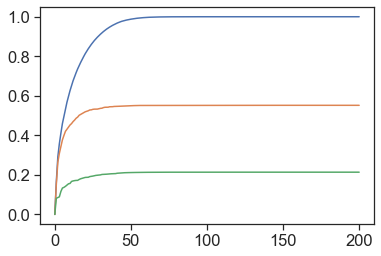

In [178]:
#this is the correct equation to testimate. This returns the corresponding D
evals = np.abs(U.T.dot(store_g1_filt).dot(V.T).diagonal())
mx = np.sum(evals)
plt.plot([0]+(np.cumsum(evals)/mx).tolist())

evals = np.abs(U.T.dot(store_g1_cv_filt).dot(V.T).diagonal())
plt.plot([0]+(np.cumsum(evals)/mx).tolist())


evals = np.abs(U.T.dot(store_g2_filt).dot(V.T).diagonal())
plt.plot([0]+(np.cumsum(evals)/mx).tolist())
#plt.ylim(.2,1)


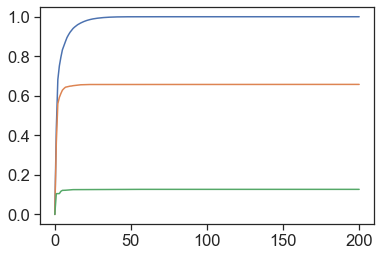

In [66]:
#this is the correct equation to testimate. This returns the corresponding D
evals = U.T.dot(store_g1_filt).dot(V.T).diagonal()**2
mx = np.sum(evals)
plt.plot([0]+(np.cumsum(evals)/mx).tolist())

evals = U.T.dot(store_g1_cv_filt).dot(V.T).diagonal()**2
plt.plot([0]+(np.cumsum(evals)/mx).tolist())


evals = U.T.dot(store_g2_filt).dot(V.T).diagonal()**2
plt.plot([0]+(np.cumsum(evals)/mx).tolist())